In [70]:
%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


In [71]:
# -.-|m { input: false, output: false, input_fold: show}

import tomlkit
import scanpy as sc
from anndata import AnnData
import pandas as pd
import numpy as np
import scvi
from scvi.external import CellAssign
import torch

from os import path
import session_info
import logging
from tempfile import TemporaryDirectory 
from os import system

logging.basicConfig(level=logging.ERROR)

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)


Global seed set to 0


Last run with scvi-tools version: 1.1.2


In [72]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
torch.set_float32_matmul_precision("high")

In [73]:
## Pipeline parameters

with open("../config.toml", "r") as f:
    config = tomlkit.parse(f.read())

In [74]:
ROOT_DIR = config["basic"]["ANALYSIS_DIR"]
DIR_SAVE = path.join(ROOT_DIR, config["basic"]["DIR_SAVE"])

In [75]:
adata = sc.read_h5ad(path.join(DIR_SAVE, "adata.h5ad"))

In [76]:
df = pd.read_csv("../resources/scHCL_DB.csv", index_col=0)

In [77]:
blood_df = df.filter(regex="Blood")
quantiles = blood_df.quantile(q=0.98, axis=0)
blood_markers_binary = blood_df.gt(quantiles, axis=1).astype("int")
blood_markers_binary = blood_markers_binary.loc[~(blood_markers_binary ==0).all(axis=1)]
markers_common = set(adata.var_names).intersection(set(blood_markers_binary.index))

adata = adata[1:500, list(markers_common)].copy()
blood_markers_binary = blood_markers_binary.loc[list(markers_common), ]

In [78]:
adata.X = adata.layers["counts"]
lib_size = adata.layers["counts"].sum(1)
adata.obs["size_factor"] = lib_size / np.mean(lib_size)

In [79]:
scvi.external.CellAssign.setup_anndata(adata, size_factor_key="size_factor")

/home/mohamed/Documents/Bioinformatics/GPM/analysis/scanpy_pipeline/preprocessing/.pixi/envs/default/lib/python3.11/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [80]:
cellassign_model = CellAssign(adata, blood_markers_binary)

In [81]:
cellassign_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs
/home/mohamed/Documents/Bioinformatics/GPM/analysis/scanpy_pipeline/preprocessing/.pixi/envs/default/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 5/400:   1%|          | 4/400 [00:38<1:00:19,  9.14s/it, v_num=1, train_loss_step=1.81e+3, train_loss_epoch=1.81e+3]

<Axes: xlabel='epoch'>

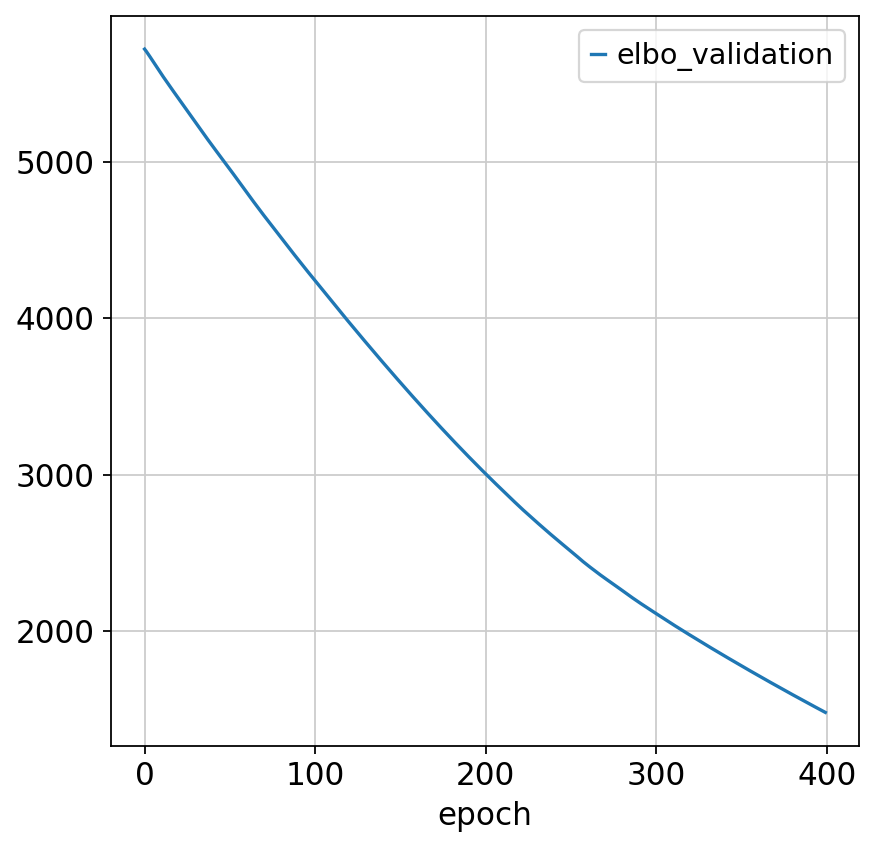

In [65]:
cellassign_model.history["elbo_validation"].plot()


In [66]:
predictions = cellassign_model.predict()
predictions.head()


,CD4.T.cell.Adult.Peripheral.Blood1.,Proliferating..B.cell.Adult.Peripheral.Blood1.,Monocyte.Adult.Peripheral.Blood1.,CD8.T.cell.Adult.Peripheral.Blood1.,NK.cell.Adult.Peripheral.Blood1.,B.cell.Adult.Peripheral.Blood1.,Macrophage.Adult.Peripheral.Blood1.,Conventional.dendritic.cell.Adult.Peripheral.Blood1.,Plasmacytoid.dendritic.cell.Adult.Peripheral.Blood1.,Neutrophil.Adult.Peripheral.Blood1.,...,Neutrophil_ELANE.high.Cord.Blood.CD34P1.,HSPC.Cord.Blood.CD34P2.,Monocyte_G0S2.high.Cord.Blood.CD34P2.,Proliferating.cell.Cord.Blood.CD34P2.,Neutrophil_MPO.high.Cord.Blood.CD34P2.,Dendritic.cell.Cord.Blood.CD34P2.,Neutrophil_ELANE.high.Cord.Blood.CD34P2.,Erythroid.Basophil.Progenitor.Cord.Blood.CD34P2.,Megakaryocyte.Cord.Blood.CD34P2.,Blood.NK.CD16..Placenta_VentoTormo.
0,1.073329e-94,2.480605e-102,1.746040e-99,7.523833e-96,5.106041e-92,1.691906e-90,2.669480e-97,7.912181e-98,7.843240e-95,2.384952e-99,...,1.005209e-88,1.195939e-57,1.663349e-82,1.312493e-54,9.491926e-62,1.216527e-97,2.845541e-87,1.000000e+00,1.546443e-77,1.283839e-110
1,2.619854e-37,6.231403e-49,3.219013e-20,1.787792e-40,3.501514e-39,7.696069e-36,2.941024e-29,1.195199e-25,9.409623e-28,3.229443e-34,...,1.364949e-38,8.020889e-32,9.998600e-01,9.018287e-27,8.030113e-30,7.865268e-28,3.844873e-30,1.527945e-32,1.768816e-44,7.615489e-41
2,3.459344e-137,1.204925e-146,1.821438e-133,4.400679e-137,3.233548e-135,7.911692e-137,7.162374e-134,8.202279e-140,4.281954e-144,2.211443e-51,...,8.987022e-125,1.766148e-117,1.807263e-108,7.536816e-126,3.647987e-112,1.298878e-135,5.799360e-124,1.000000e+00,4.267342e-156,1.125406e-145
3,6.557688e-99,2.226577e-129,1.472017e-36,5.730314e-92,5.097377e-107,7.260335e-93,2.742127e-34,4.867214e-54,2.986300e-76,1.489315e-86,...,1.055545e-95,2.030062e-100,1.101091e-54,9.010426e-111,1.177407e-96,9.216718e-72,2.059558e-79,8.556843e-110,5.707199e-152,1.531939e-149
4,2.283832e-04,3.658355e-11,3.331607e-11,1.671060e-12,1.645735e-06,2.834246e-14,3.784931e-15,1.397525e-14,4.461173e-08,2.029818e-09,...,2.006986e-14,1.290441e-05,1.072140e-06,9.879532e-09,2.577109e-08,5.735151e-13,2.153129e-15,1.771553e-30,1.649809e-07,9.118807e-01


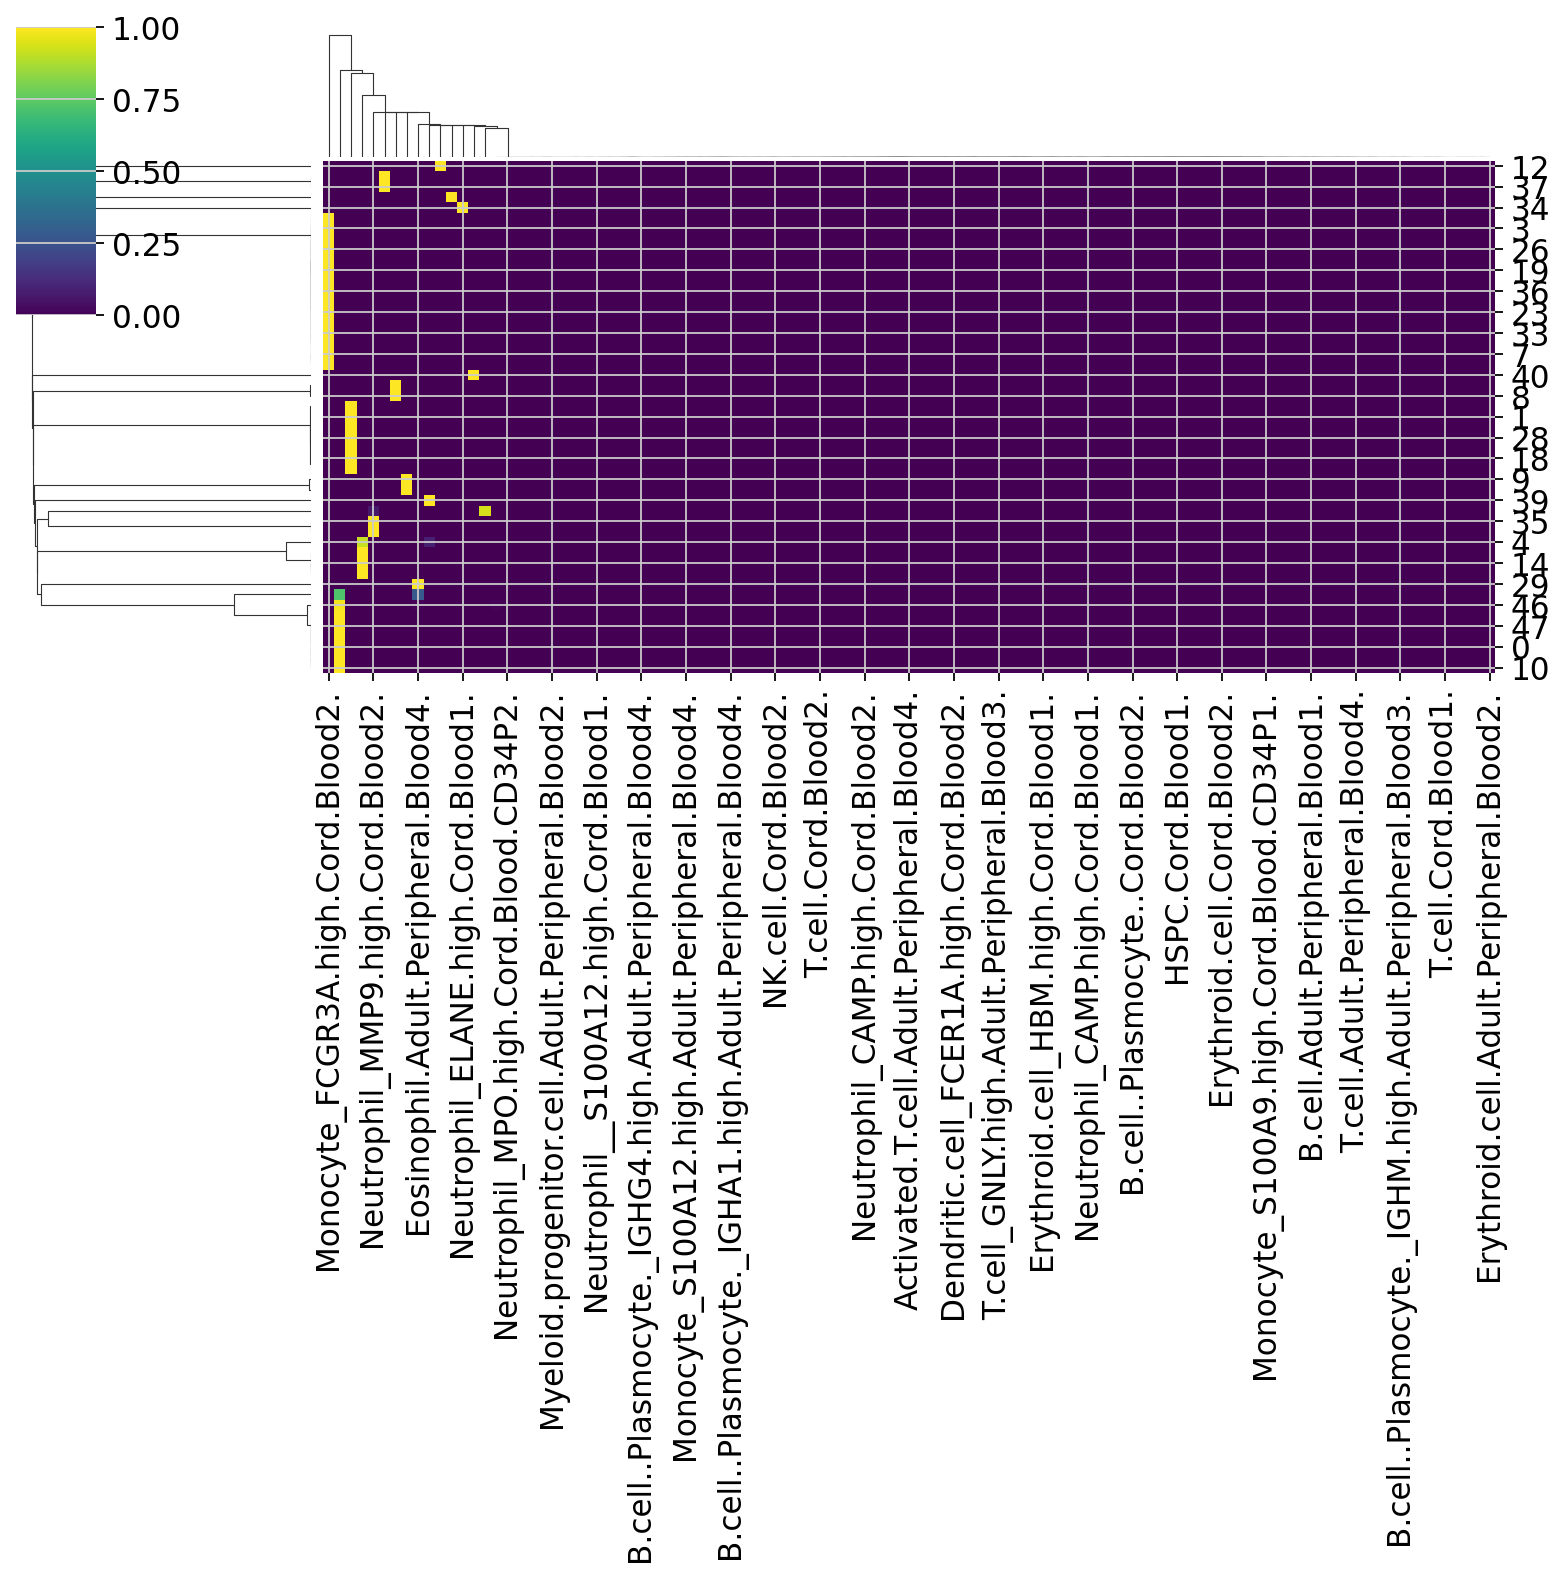

In [68]:
import seaborn as sns
sns.clustermap(predictions, cmap="viridis")


In [69]:
adata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values